In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json
from bench_utils import parse_intersection_data 

In [2]:
# Geometries
manual_data, _ = parse_intersection_data("manual")
special_cases, _ = parse_intersection_data("latest_export.json", strip_precision=True)
world_data, world_data_stats = parse_intersection_data("world.json", 100, strip_precision=False)
lund_data, lund_data_stats = parse_intersection_data("lund.json", 1000)

In [3]:
SHOW_COORDINATES = True
SHOW_GEOMETRIES = True
SHOW_INTERSECTING_POINTS = True
SHOW_COMMON_BOUNDING_BOX = False
SHOW_BOUNDING_BOXES = False

In [4]:
import intersection.first_bin_search
import intersection.chunk_bbox_intersection
binary_intersection = intersection.first_bin_search.binary_intersection
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting
chunk_bbox_intersection = intersection.chunk_bbox_intersection.intersection

from intersection.plotting import *

from algos.alg_fpd_extended import FpdExtended
fpd = FpdExtended()

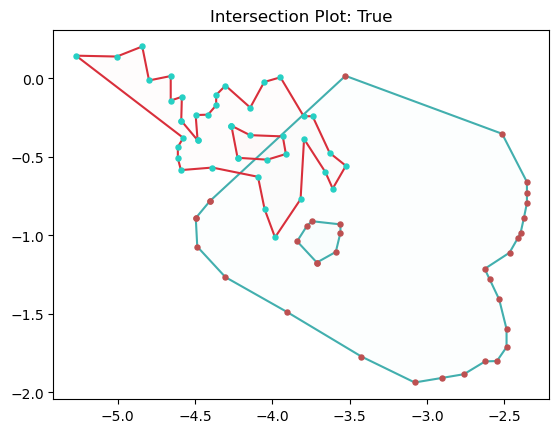

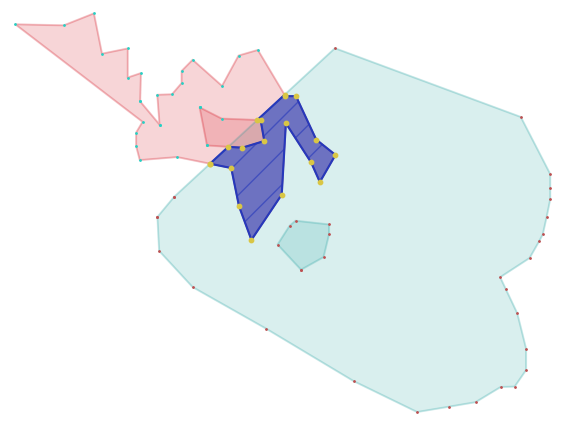

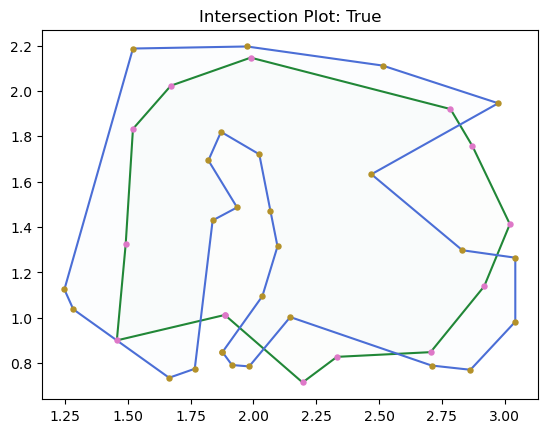

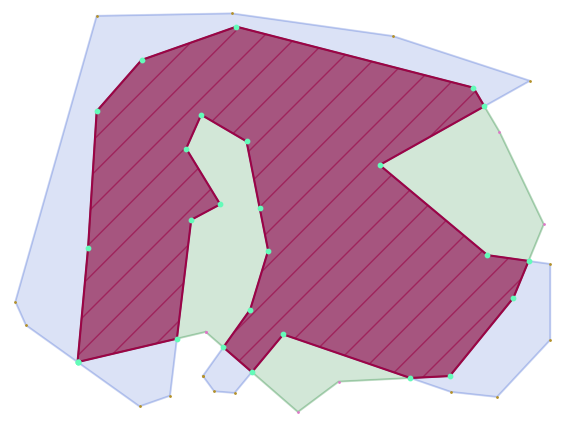

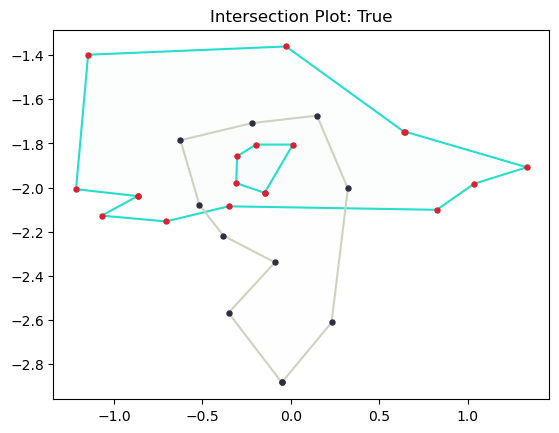

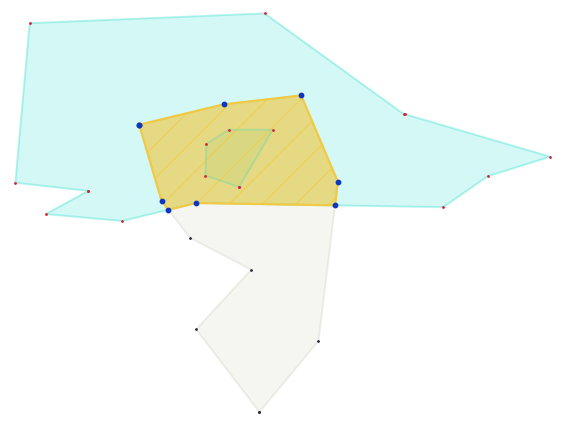

Above FAILED!
Expected shape: POLYGON ((-0.3516658 -2.0847183, -0.4845426968749755 -2.110500410295424, -0.5170542 -2.0768278, -0.6238394 -1.7855954, -0.2209679 -1.7079335, 0.1479265 -1.6739564, 0.3226659 -2.0040197, 0.3090497385888933 -2.093599707729461, -0.3516658 -2.0847183), (0.012018 -1.8050109, -0.1966985 -1.8050109, -0.3034837 -1.8584035, -0.3083376 -1.9797504, -0.1481598 -2.0234352, 0.012018 -1.8050109))
Returned shape: POLYGON ((-0.6238394 -1.7855954, -0.2209679 -1.7079335, 0.1479265 -1.6739564, 0.3226659 -2.0040197, 0.3090497385888933 -2.093599707729461, -0.3516658 -2.0847183, -0.4845426968749755 -2.110500410295424, -0.5170542 -2.0768278, -0.6238394 -1.7855954))


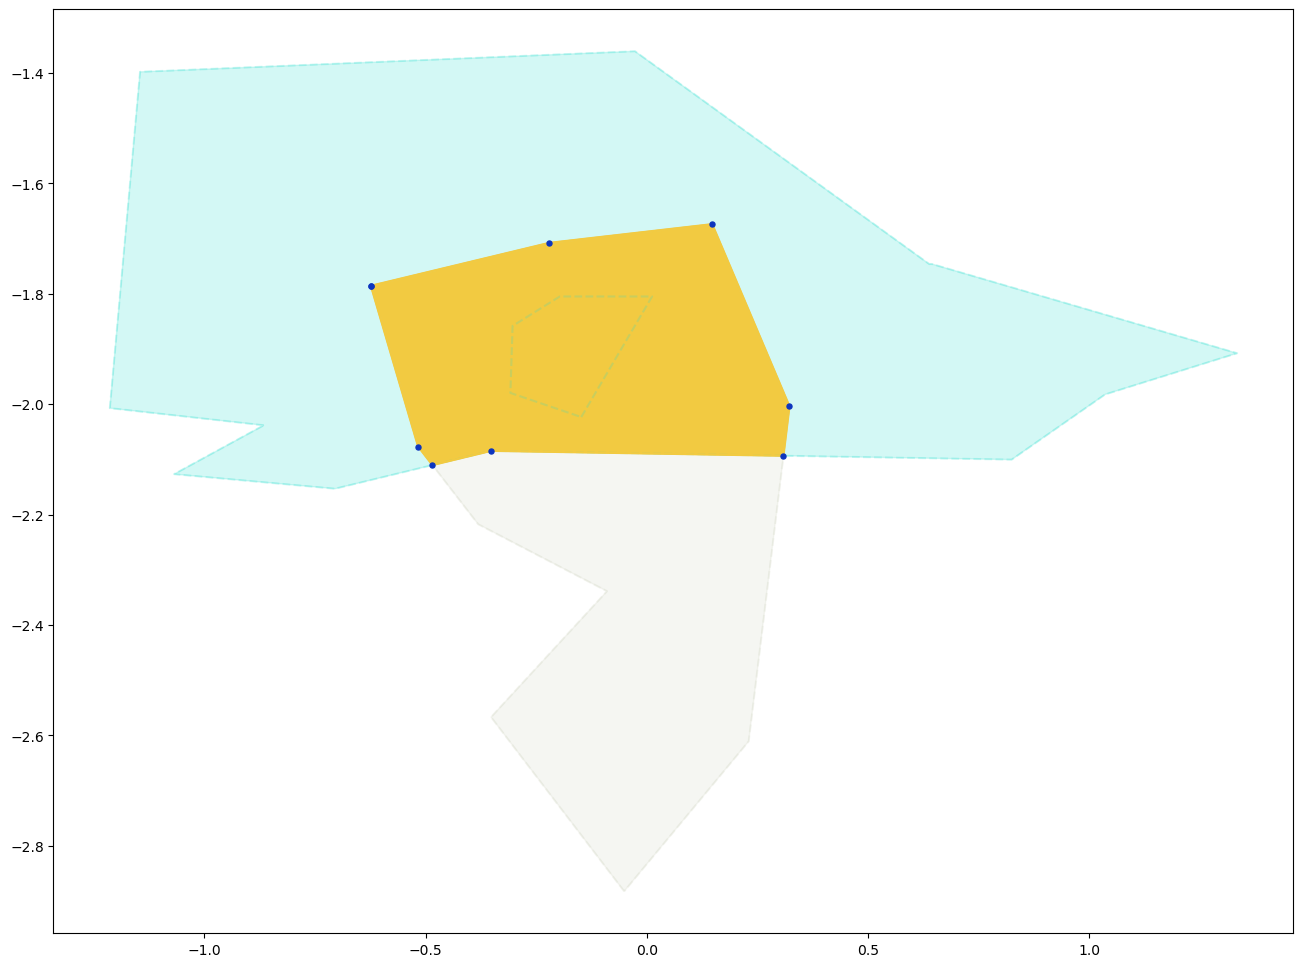

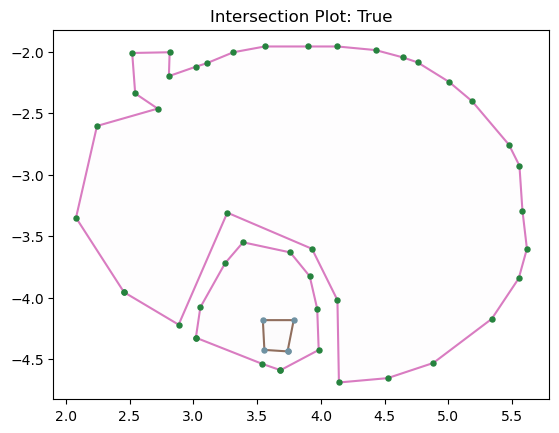

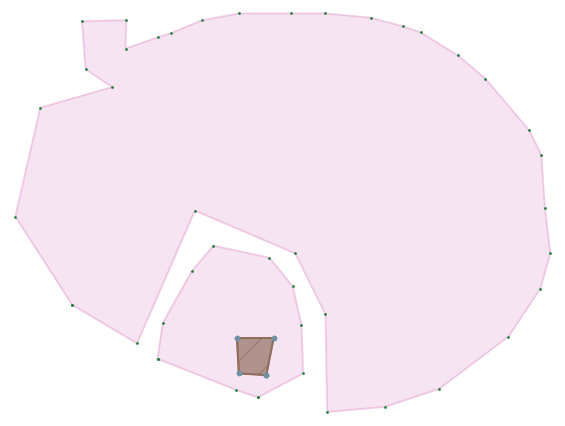

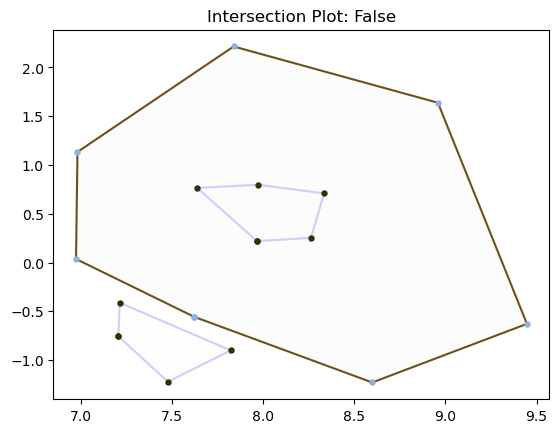

Above FAILED!
Expected shape: POLYGON ((7.637255 0.7649043, 7.9736232 0.7969393, 8.3340177 0.7088429, 8.2619388 0.2523432, 7.9656145 0.2203081, 7.637255 0.7649043))
Returned shape: POLYGON EMPTY


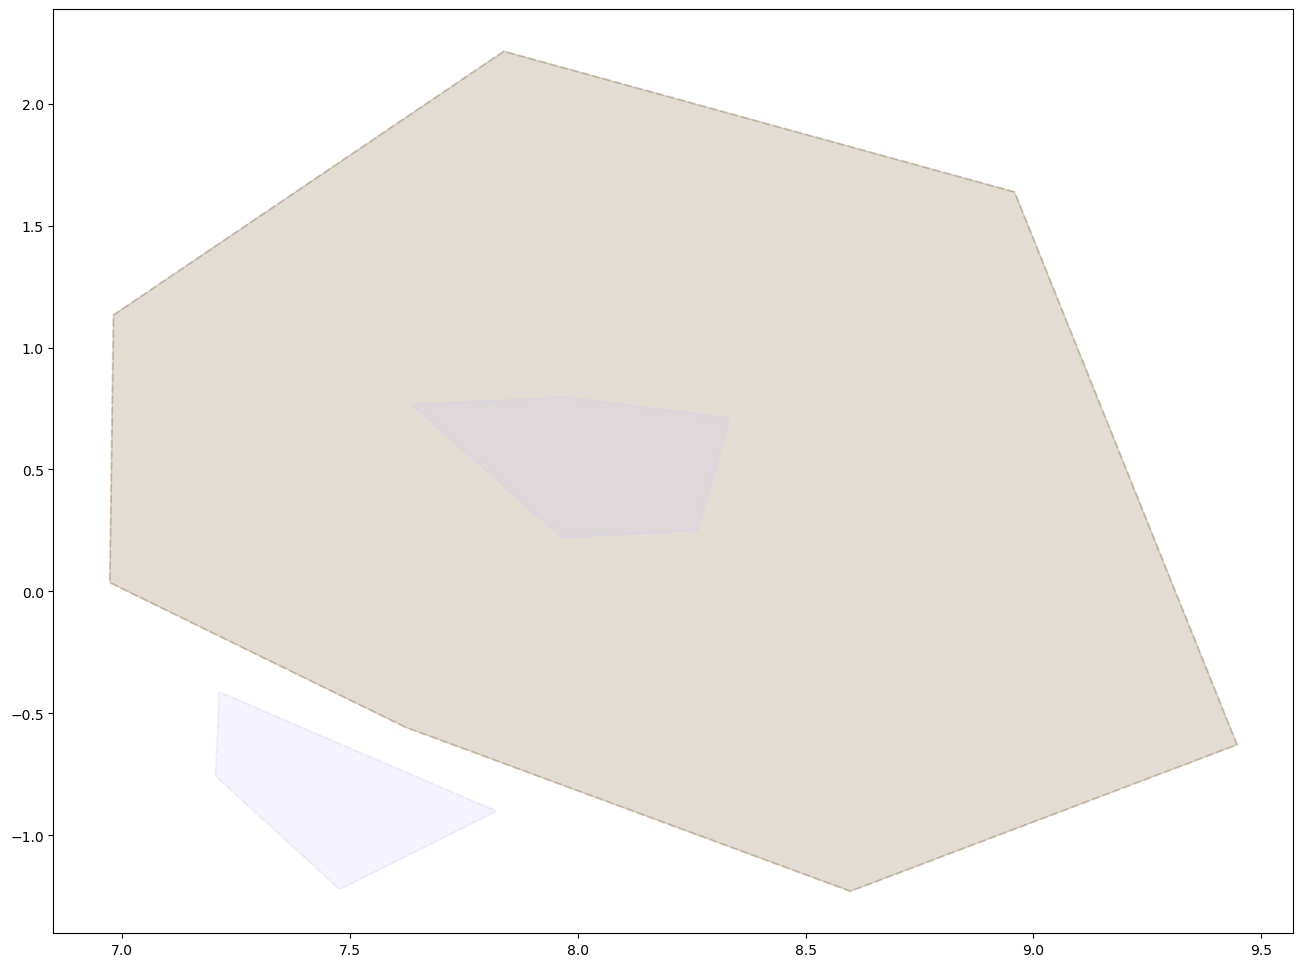

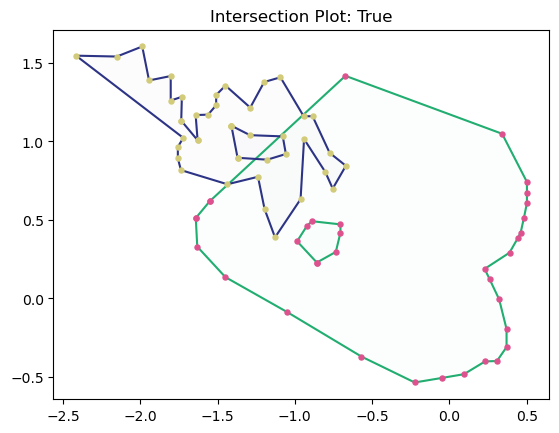

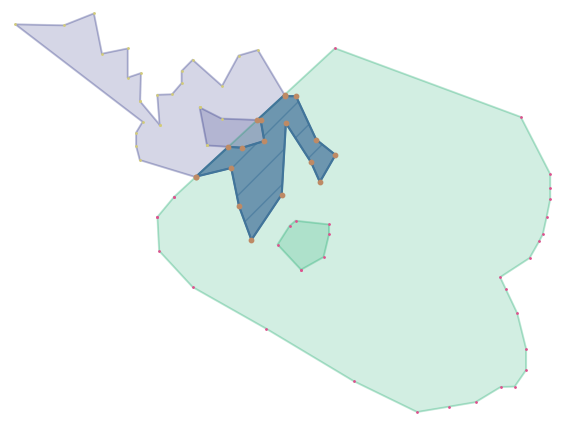

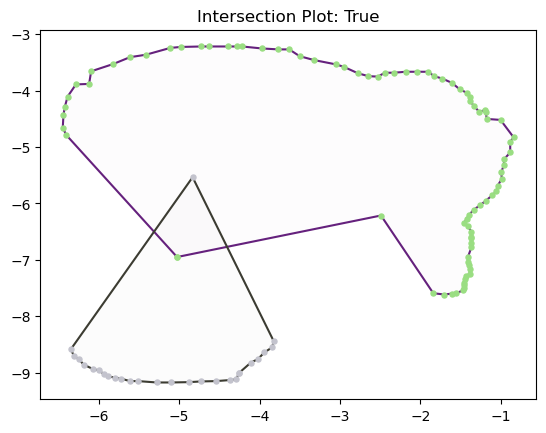

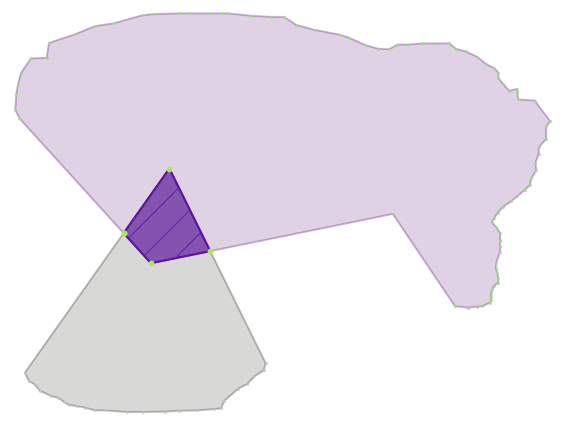

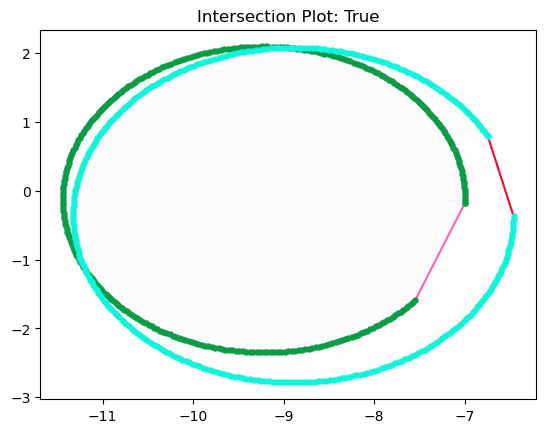

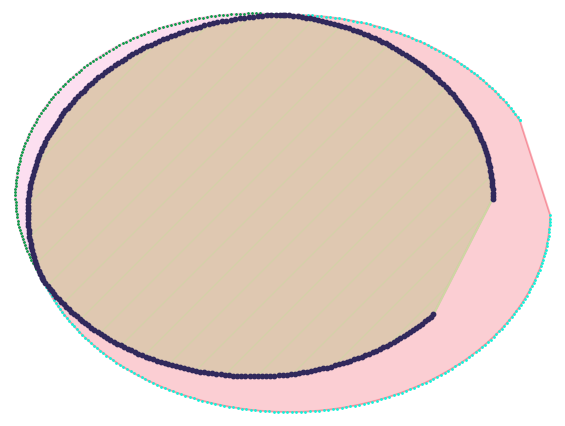

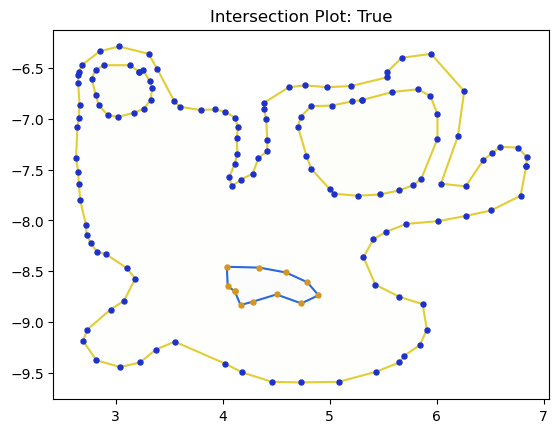

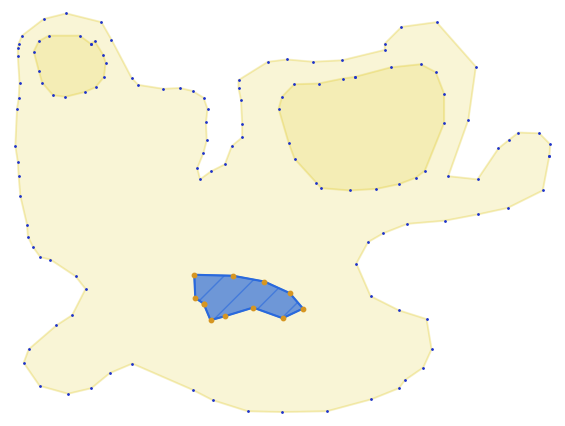

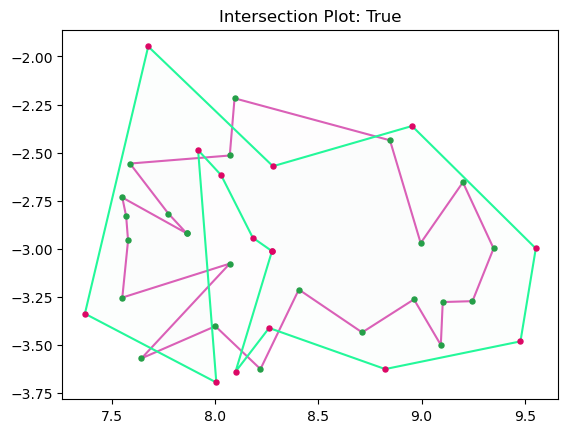

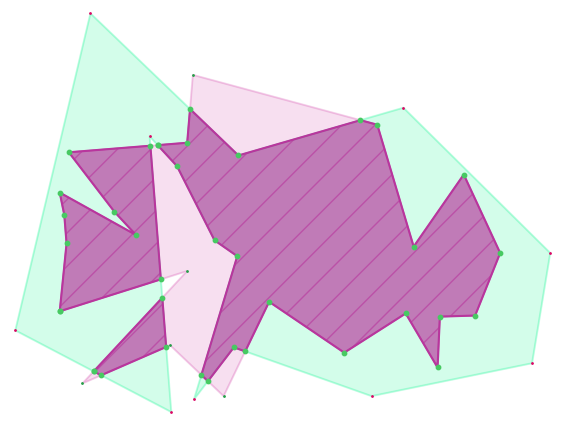

Done. Passed: 9 of 11.


Exception: Failed intersection!

In [5]:
total = 0
passed = 0
def evaluate_dataset(data, plot, total, passed):
    for g1, g2 in data:
        #is_intersecting, intersect_points = binary_intersection(g1, g2)

        _, b1 = fpd.compress(g1)
        _, b2 = fpd.compress(g2)
        exp_boolean = shapely.intersects(g1, g2)
        #is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp_boolean, True)
        is_intersecting = fpd.is_intersecting((b1, b2))[1]

        exp_shape = shapely.intersection(g1, g2)
        intersection = chunk_bbox_intersection((b1, b2), exp_boolean, True)

        if plot and exp_boolean: # Now only plotting intersecting shapes
            if False: # Plot chunks?
                plot_chunks_bounds(b1, True, avoid_show=True)
                plot_chunks_bounds(b2, True, avoid_create_frame=True, avoid_show=True)
            geoms = (g1, g2)
            for g in geoms:
                plot_geometry(g, SHOW_GEOMETRIES)
                plot_geometry_bbox(g, SHOW_BOUNDING_BOXES)
                plot_coordinates(g, SHOW_COORDINATES)
            
            plot_common_bbox(geoms, SHOW_COMMON_BOUNDING_BOX)
            #plot_intersecting_points(intersect_points, legends, SHOW_INTERSECTING_POINTS)

            if SHOW_COORDINATES or SHOW_GEOMETRIES or SHOW_INTERSECTING_POINTS or SHOW_COMMON_BOUNDING_BOX or SHOW_BOUNDING_BOXES:
                plt.title("Intersection Plot: " + ('True' if is_intersecting else 'False'))
                plt.show()


            PLOT_RESULTING_INTERSECTION = True
            if is_intersecting and PLOT_RESULTING_INTERSECTION:
                create_canvas(zoom=1.1, no_frame=True)
                for g in geoms:
                    plot_geometry(g, SHOW_GEOMETRIES, alpha=0.2, fill_alpha=0.2)
                    plot_coordinates(g, SHOW_COORDINATES, size=1)
                
                plot_geometry(intersection, fill_alpha=0.6, hatch=True)
                plot_coordinates(intersection, size=10)
                #plt.title("Intersecting Shape")
                plt.show()

           
        total += 1
        if is_intersecting == exp_boolean and exp_shape.equals(intersection):
            passed += 1
        #     if not exp_shape.is_empty:
        #         create_canvas()
        #         plot_geometry(g1,alpha=0.2)
        #         plot_geometry(g2,alpha=0.2)
        #         #plot_geometry(exp_shape, solid=False)
        #         plot_geometry(intersection)
        #         plot_coordinates(intersection)
        #         plt.show()
            
        else:
            print("Above FAILED!")
            print('Expected shape:', exp_shape)
            print('Returned shape:', intersection)
            create_canvas()
            plot_geometry(g1,alpha=0.2, fill_alpha=0.2, solid=False)
            plot_geometry(g2,alpha=0.2, fill_alpha=0.2, solid=False)
            #plot_geometry(exp_shape, solid=False)
            plot_geometry(intersection, fill_alpha=1.0)
            plot_coordinates(intersection)
            plt.show()
        if total % 100 == 0:
            print(f"Passed {passed} of {total}. Total in set: {len(data)}")
    return total, passed

#total, passed = evaluate_dataset(manual_data, True, total, passed) # Second param: PLOT?
total, passed = evaluate_dataset(special_cases, True, total, passed)
#total, passed = evaluate_dataset(world_data, True, total, passed)
#total, passed = evaluate_dataset(lund_data, True, total, passed)

print(f'Done. Passed: {passed} of {total}.')
if passed != total:
    raise(Exception("Failed intersection!"))

#POLYGON ((6.5 6.5, 8 5, 4 4, 6.5 6.5))